# Generate Data

This bundle uses simple synthetic data for training and testing. Using `create_test_image_3d` we'll create images of spheres with labels for each divided into 3 classes distinguished by intensity. The network will be able to train very quickly on this of course but it's for demonstration purposes and your specialised bundle will by modified for your data and its layout. 

Assuming this notebook is being run from the `docs` directory it will create two new directories in the root of the bundle, `train_data` and `test_data`.

First imports:

In [7]:
import os
import json
import random

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

plt.rcParams["image.interpolation"] = "none"

As shown here, the images are spheres in a 3D volume with associated labels:

In [8]:
def generate_images(image_size=128, border=20, shape_probabilities=None, shape_sizes=None):
    image = np.zeros((image_size, image_size))

    if shape_probabilities is None:
        shape_probabilities = [0.25, 0.2, 0.3, 0.25]  # Default probabilities for circle, triangle, rectangle

    if shape_sizes is None:
        shape_sizes = [(10, 30), (20, 40), (20, 40)]  # Default size ranges for circle, triangle, rectangle

    def draw_zero(image):
        return image

    def draw_circle(image):
        center_x, center_y = np.random.randint(border, image_size - border), np.random.randint(border, image_size - border)
        radius = np.random.randint(*shape_sizes[0])
        y, x = np.ogrid[-center_x:image_size-center_x, -center_y:image_size-center_y]
        mask = x ** 2 + y ** 2 <= radius ** 2
        image[mask] = 1
        return image

    def draw_triangle(image):
        size = np.random.randint(*shape_sizes[1])
        x1, y1 = np.random.randint(border, image_size - border), np.random.randint(border, image_size - border)
        x2, y2 = x1 + size, y1
        x3, y3 = x1 + size // 2, y1 - int(size * np.sqrt(3) / 2)
        triangle = np.array([[x1, x2, x3], [y1, y2, y3]])
        mask = plt.matplotlib.path.Path(np.transpose(triangle)).contains_points(
            np.array([(i, j) for i in range(image_size) for j in range(image_size)])
        )
        image[mask.reshape(image_size, image_size)] = 1
        return image

    def draw_rectangle(image):
        x1, y1 = np.random.randint(border, image_size - border), np.random.randint(border, image_size - border)
        x2, y2 = x1 + np.random.randint(*shape_sizes[2]), y1 + np.random.randint(*shape_sizes[2])
        image[x1:x2, y1:y2] = 1
        return image

    label, shape = random.choices([(0, draw_zero), (1, draw_circle), (2, draw_triangle), (3, draw_rectangle)], weights=shape_probabilities)[0]
    image = shape(image)

    return image, label

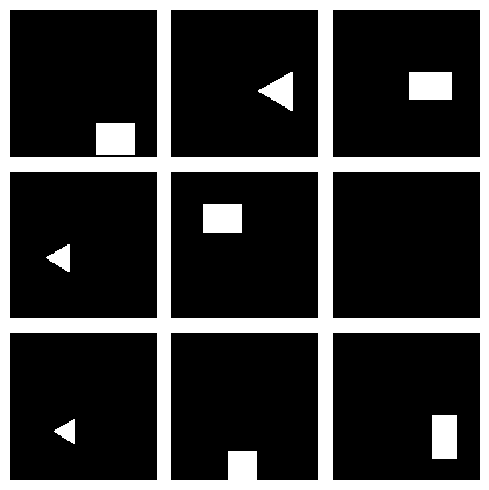

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(5, 5))
for i, ax in enumerate(axes.flatten()):
    for j in range(9):
        images, label = generate_images(128)
        ax.imshow(images, cmap='gray')
        ax.axis('off')
plt.tight_layout()
plt.show()

50 image/label pairs are now generated into the directory `../data/train_data`, assuming this notebook is run from the `docs` directory this will be in the bundle root:

In [10]:
num_images = 50
out_dir = os.path.abspath("../data/train_data")
os.makedirs(out_dir, exist_ok=True)

train_data = []
for i in range(num_images):
    data = {}
    img, lbl = generate_images(128)
    n = nib.Nifti1Image(img, np.eye(4))
    train_file_path = os.path.join(out_dir, f"img{i:02}.nii.gz")
    nib.save(n, train_file_path)

    data["image"] = train_file_path
    data["label"] = lbl
    train_data.append(data)

with open(os.path.abspath("../data/train_samples.json"), "w") as f:
    json.dump(train_data, f, indent=2)

We'll also generate some test data in a separate folder:

In [11]:
num_images = 10
out_dir = os.path.abspath("../data/test_data")
os.makedirs(out_dir, exist_ok=True)

train_data = []
for i in range(num_images):
    data = {}
    img, lbl = generate_images(128)
    n = nib.Nifti1Image(img, np.eye(4))
    train_file_path = os.path.join(out_dir, f"img{i:02}.nii.gz")
    nib.save(n, train_file_path)

    data["image"] = train_file_path
    data["label"] = lbl
    train_data.append(data)

with open(os.path.abspath("../data/test_samples.json"), "w") as f:
    json.dump(train_data, f, indent=2)

In [12]:
!ls {out_dir}

img00.nii.gz  img02.nii.gz  img04.nii.gz  img06.nii.gz	img08.nii.gz
img01.nii.gz  img03.nii.gz  img05.nii.gz  img07.nii.gz	img09.nii.gz
